In [3]:

import tensorflow as tf
from tensorflow.keras import models, layers

import matplotlib.pyplot as plt
from IPython.display import HTML
print('hello')

hello


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "wheatleaf",

    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 407 files belonging to 3 classes.


2022-07-22 22:56:26.587665: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
class_names = dataset.class_names
class_names

['Healthy', 'septoria', 'stripe_rust']

2022-07-22 22:56:26.754036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-22 22:56:36.852404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 256
2022-07-22 22:56:38.768485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


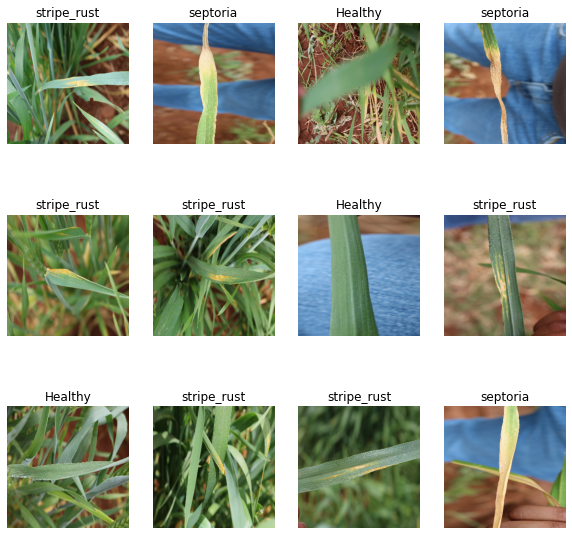

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:

train_size = 0.8
len(dataset)*train_size

10.4

In [9]:
train_ds = dataset.take(10)
len(train_ds)

10

In [10]:
test_ds = dataset.skip(10)
len(test_ds)

3

In [11]:
val_size=0.1
len(dataset)*val_size

1.3

In [12]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [13]:
test_ds = test_ds.skip(1)
len(test_ds)

2

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

10

In [17]:
len(test_ds)

2

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


2022-07-22 22:56:52.417594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 208 of 256
2022-07-22 22:56:55.091033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2022-07-22 22:56:56.477215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-07-22 22:57:02.745810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 5 of 10000
2022-07-22 22:57:02.898706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2022-07-22 22:57:02.899927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-07-22 22:57:02.899952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-07-22 22:57:02.906274: I tensorflow/cor

10/10 [==============================] - ETA: 0s - loss: 1.0480 - accuracy: 0.5080

2022-07-22 22:57:30.838115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 139 of 256
2022-07-22 22:57:38.684283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2022-07-22 22:57:40.292022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-07-22 22:57:42.401404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2 of 10000
2022-07-22 22:57:47.311781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2022-07-22 22:57:47.338712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-07-22 22:57:47.344749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


10/10 [==============================] - 66s 5s/step - loss: 1.0480 - accuracy: 0.5080 - val_loss: 0.9829 - val_accuracy: 0.5625
Epoch 2/50
10/10 [==============================] - 24s 2s/step - loss: 1.0196 - accuracy: 0.5080 - val_loss: 0.9678 - val_accuracy: 0.5625
Epoch 3/50
10/10 [==============================] - 20s 2s/step - loss: 0.9768 - accuracy: 0.5080 - val_loss: 0.9102 - val_accuracy: 0.5625
Epoch 4/50
10/10 [==============================] - 16s 2s/step - loss: 0.8441 - accuracy: 0.5627 - val_loss: 0.9650 - val_accuracy: 0.5938
Epoch 5/50
10/10 [==============================] - 15s 1s/step - loss: 0.7464 - accuracy: 0.6720 - val_loss: 0.6235 - val_accuracy: 0.7188
Epoch 6/50
10/10 [==============================] - 16s 2s/step - loss: 0.6423 - accuracy: 0.7203 - val_loss: 0.5146 - val_accuracy: 0.7500
Epoch 7/50
10/10 [==============================] - 14s 1s/step - loss: 0.6082 - accuracy: 0.7299 - val_loss: 0.5684 - val_accuracy: 0.7500
Epoch 8/50
10/10 [=============

In [26]:

scores = model.evaluate(test_ds)


2022-07-22 23:09:35.248616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 198 of 256
2022-07-22 23:09:38.358538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2022-07-22 23:09:39.904639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-07-22 23:09:45.919484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 5 of 10000
2022-07-22 23:09:46.060534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2022-07-22 23:09:46.082880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-07-22 23:09:46.082934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-07-22 23:09:46.083202: I tensorflow/cor

2/2 [==============================] - 22s 285ms/step - loss: 0.1210 - accuracy: 0.9688


first image to predict
actual label: stripe_rust
predicted label: stripe_rust


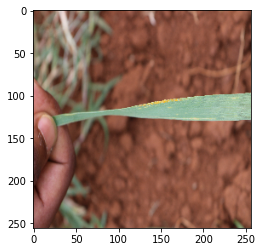

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

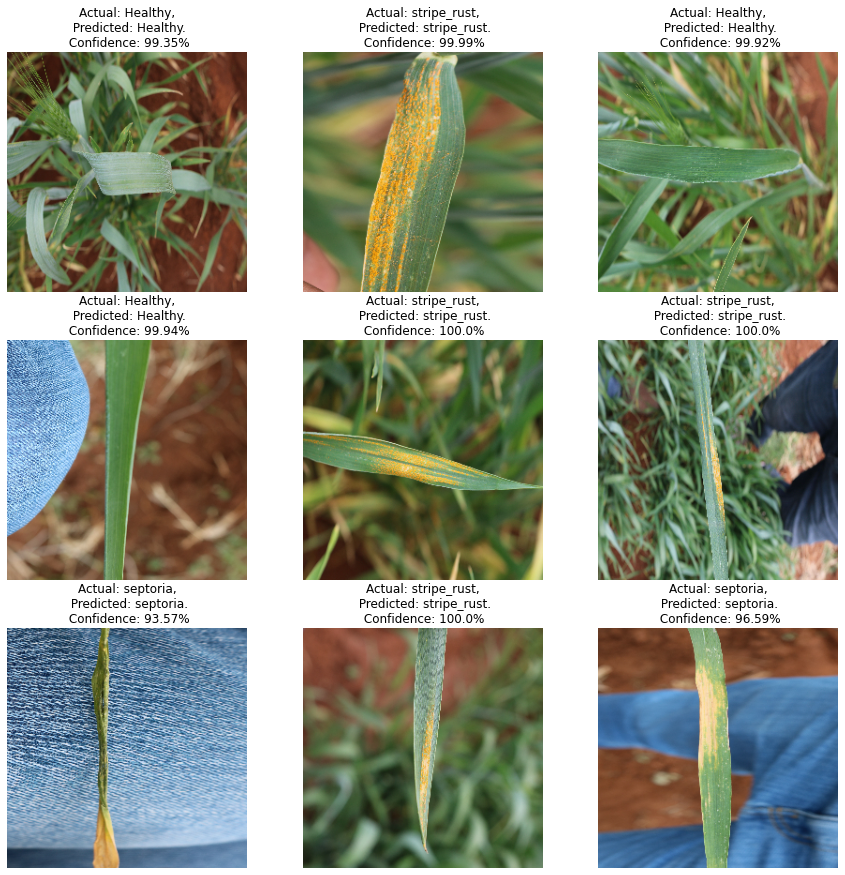

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [30]:
import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../saved_models/model.h5")
